#IT3 - Etude d'Ablation - T5 Summarization

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')
PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'
os.makedirs(PROJECT_DIR, exist_ok=True)

print(f"📁 Projet : {PROJECT_DIR}")

Mounted at /content/drive
📁 Projet : /content/drive/MyDrive/RCP217_Projet_Summarization


In [7]:
# Installation des dépendances
!pip install transformers torch rouge-score sentencepiece -q

  Preparing metadata (setup.py) ... done


## Analyse de la distribution des longueurs d'articles

📊 ANALYSE DE LA DISTRIBUTION DES LONGUEURS
Total articles : 15000

📏 STATISTIQUES GÉNÉRALES
Moyenne : 759 mots
Médiane : 697 mots
Écart-type : 401 mots
Min : 0 mots
Max : 2171 mots

📊 PERCENTILES
P10 : 290 mots
P25 : 442 mots
P50 : 697 mots
P75 : 1015 mots
P90 : 1322 mots
P95 : 1528 mots
P99 : 1862 mots

📊 DISTRIBUTION PAR TRANCHES
| Longueur (mots) | Nombre | Pourcentage |
|-----------------|--------|-------------|
| <500            |   4669 |   31.2%     |
| 500-800         |   4133 |   27.6%     |
| 800-1000        |   2290 |   15.3%     |
| >1000           |   3887 |   25.9%     |
| TOTAL           |  15000 |  100.0%     |

📊 Graphique sauvegardé : length_distribution_analysis.png


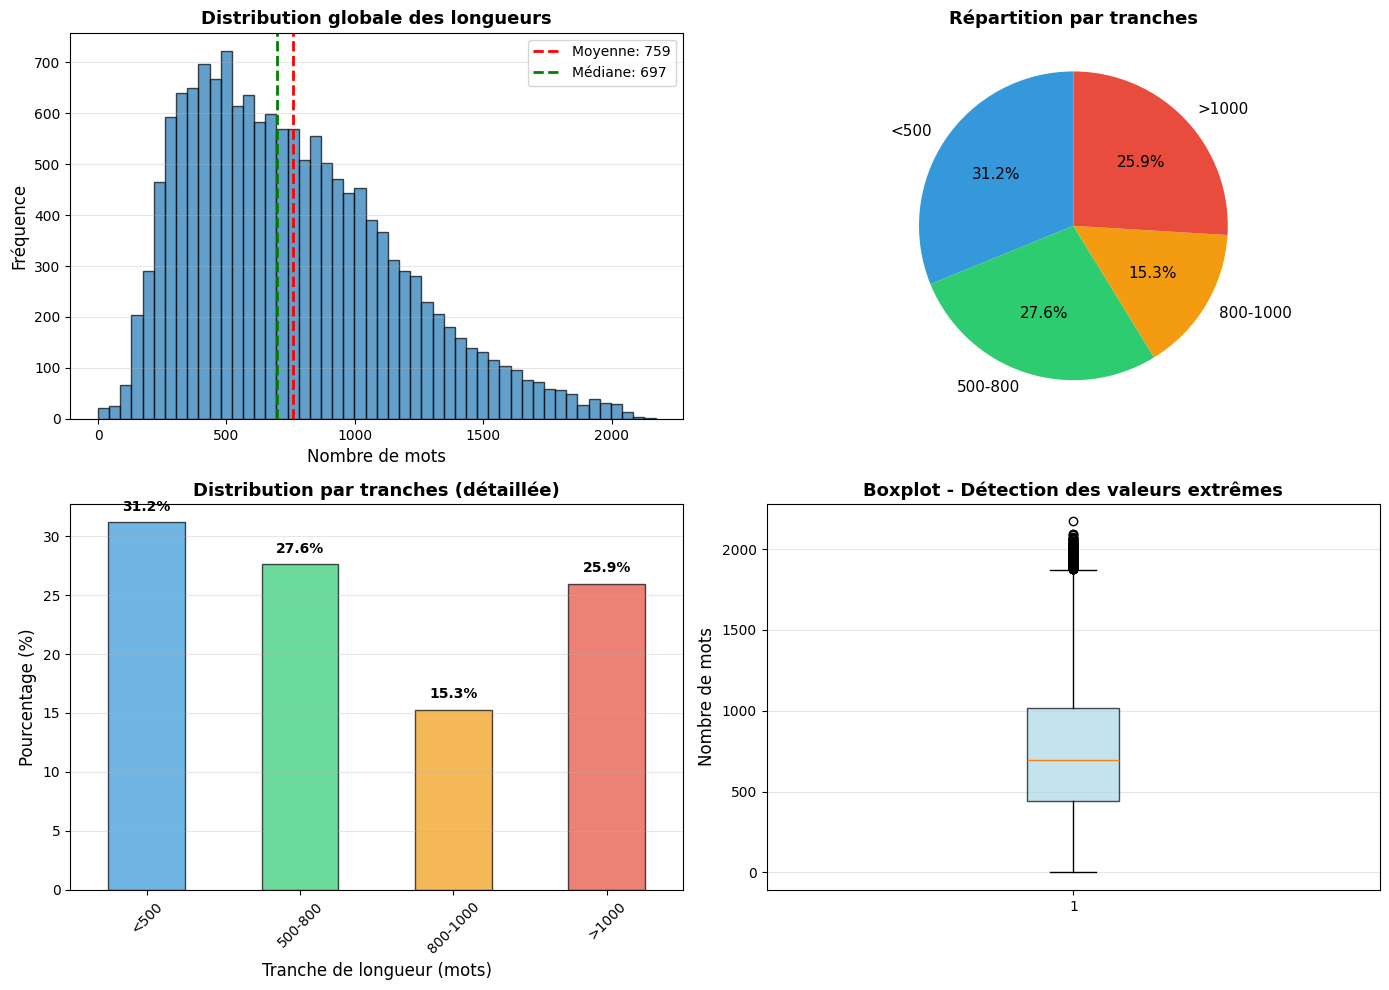


⚠️  ANALYSE TRONCATURE T5 (512 tokens)

Limite approximative T5 : 384 mots (512 tokens)
Articles dépassant cette limite : 12135 (80.9%)
Articles dans la limite : 2865 (19.1%)

Pour les articles dépassant la limite :
  Longueur moyenne : 874 mots
  Troncature moyenne : 56.0% du contenu

🔍 FOCUS SUR ARTICLES >1000 MOTS
Nombre : 3887 articles
Pourcentage : 25.9%
Longueur moyenne : 1307 mots
Longueur max : 2171 mots

Troncature moyenne pour >1000 mots : 70.6% du contenu

📌 EXEMPLE : Article de 1500 mots
  Tokens estimés : 2000
  Tokens gardés : 512
  Tokens perdus : 1488
  Pourcentage perdu : 74.4%

💾 Fichiers sauvegardés :
  • length_distribution_stats.csv
  • length_per_article.csv
  • length_distribution_analysis.png

✅ Analyse terminée !

📋 TABLEAU POUR LE RAPPORT

| Longueur (mots) | % corpus | Articles | ROUGE-1* |
|-----------------|----------|----------|----------|
| <500            |   31.2%  |     4669 | À mesurer|
| 500-800         |   27.6%  |     4133 | À mesurer|
| 800-1000 

In [4]:
"""
Analyse de la distribution des longueurs d'articles
Pour l'étude d'ablation IT3
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CHARGEMENT DES DONNÉES
# ==========================================

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

# Charger les données
train_df = pd.read_pickle(f'{PROJECT_DIR}/train_data.pkl')
val_df = pd.read_pickle(f'{PROJECT_DIR}/val_data.pkl')
test_df = pd.read_pickle(f'{PROJECT_DIR}/test_data.pkl')

# Combiner pour analyse globale
all_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

print("📊 ANALYSE DE LA DISTRIBUTION DES LONGUEURS")
print("="*60)
print(f"Total articles : {len(all_df)}")

# ==========================================
# CALCUL DES LONGUEURS
# ==========================================

# Longueur en mots
all_df['article_word_count'] = all_df['article'].apply(lambda x: len(x.split()))

# Statistiques générales
print("\n📏 STATISTIQUES GÉNÉRALES")
print("="*60)
print(f"Moyenne : {all_df['article_word_count'].mean():.0f} mots")
print(f"Médiane : {all_df['article_word_count'].median():.0f} mots")
print(f"Écart-type : {all_df['article_word_count'].std():.0f} mots")
print(f"Min : {all_df['article_word_count'].min():.0f} mots")
print(f"Max : {all_df['article_word_count'].max():.0f} mots")

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print("\n📊 PERCENTILES")
print("="*60)
for p in percentiles:
    value = np.percentile(all_df['article_word_count'], p)
    print(f"P{p:2d} : {value:.0f} mots")

# ==========================================
# DISTRIBUTION PAR TRANCHES
# ==========================================

# Définir les tranches
bins = [0, 500, 800, 1000, float('inf')]
labels = ['<500', '500-800', '800-1000', '>1000']

all_df['length_category'] = pd.cut(
    all_df['article_word_count'],
    bins=bins,
    labels=labels
)

# Calculer les pourcentages
distribution = all_df['length_category'].value_counts(normalize=True).sort_index() * 100

print("\n📊 DISTRIBUTION PAR TRANCHES")
print("="*60)
print("| Longueur (mots) | Nombre | Pourcentage |")
print("|-----------------|--------|-------------|")

for cat in labels:
    count = (all_df['length_category'] == cat).sum()
    pct = distribution[cat]
    print(f"| {cat:<15} | {count:6d} | {pct:6.1f}%     |")

print(f"| {'TOTAL':<15} | {len(all_df):6d} | {'100.0':>6}%     |")

# ==========================================
# VISUALISATION
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Graphique 1 : Histogramme général
axes[0, 0].hist(all_df['article_word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(all_df['article_word_count'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Moyenne: {all_df["article_word_count"].mean():.0f}')
axes[0, 0].axvline(all_df['article_word_count'].median(), color='green',
                   linestyle='--', linewidth=2, label=f'Médiane: {all_df["article_word_count"].median():.0f}')
axes[0, 0].set_xlabel('Nombre de mots', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution globale des longueurs', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Graphique 2 : Pie chart par tranches
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
axes[0, 1].pie(distribution, labels=labels, autopct='%1.1f%%',
               startangle=90, colors=colors, textprops={'fontsize': 11})
axes[0, 1].set_title('Répartition par tranches', fontsize=13, fontweight='bold')

# Graphique 3 : Barplot par tranches
distribution.plot(kind='bar', ax=axes[1, 0], color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Tranche de longueur (mots)', fontsize=12)
axes[1, 0].set_ylabel('Pourcentage (%)', fontsize=12)
axes[1, 0].set_title('Distribution par tranches (détaillée)', fontsize=13, fontweight='bold')
axes[1, 0].set_xticklabels(labels, rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Ajouter valeurs sur barres
for i, (cat, val) in enumerate(distribution.items()):
    axes[1, 0].text(i, val + 1, f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Graphique 4 : Boxplot pour détecter outliers
axes[1, 1].boxplot(all_df['article_word_count'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 1].set_ylabel('Nombre de mots', fontsize=12)
axes[1, 1].set_title('Boxplot - Détection des valeurs extrêmes', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('length_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("\n📊 Graphique sauvegardé : length_distribution_analysis.png")
plt.show()

# ==========================================
# ANALYSE PAR RAPPORT À LA LIMITE T5 (512 tokens)
# ==========================================

print("\n⚠️  ANALYSE TRONCATURE T5 (512 tokens)")
print("="*60)

# Estimation : 1 token ≈ 0.75 mots en moyenne pour l'anglais
TOKEN_LIMIT = 512
WORDS_PER_TOKEN = 0.75
WORD_LIMIT_APPROX = TOKEN_LIMIT * WORDS_PER_TOKEN  # ~384 mots

all_df['exceeds_t5_limit'] = all_df['article_word_count'] > WORD_LIMIT_APPROX

pct_exceeding = (all_df['exceeds_t5_limit'].sum() / len(all_df)) * 100

print(f"\nLimite approximative T5 : {WORD_LIMIT_APPROX:.0f} mots (512 tokens)")
print(f"Articles dépassant cette limite : {all_df['exceeds_t5_limit'].sum()} ({pct_exceeding:.1f}%)")
print(f"Articles dans la limite : {(~all_df['exceeds_t5_limit']).sum()} ({100-pct_exceeding:.1f}%)")

# Troncature moyenne pour articles dépassant
exceeding_df = all_df[all_df['exceeds_t5_limit']]
if len(exceeding_df) > 0:
    avg_truncation = (exceeding_df['article_word_count'].mean() - WORD_LIMIT_APPROX) / exceeding_df['article_word_count'].mean() * 100
    print(f"\nPour les articles dépassant la limite :")
    print(f"  Longueur moyenne : {exceeding_df['article_word_count'].mean():.0f} mots")
    print(f"  Troncature moyenne : {avg_truncation:.1f}% du contenu")

# ==========================================
# ANALYSE POUR ARTICLES >1000 MOTS
# ==========================================

print("\n🔍 FOCUS SUR ARTICLES >1000 MOTS")
print("="*60)

long_articles = all_df[all_df['article_word_count'] > 1000]

if len(long_articles) > 0:
    print(f"Nombre : {len(long_articles)} articles")
    print(f"Pourcentage : {len(long_articles)/len(all_df)*100:.1f}%")
    print(f"Longueur moyenne : {long_articles['article_word_count'].mean():.0f} mots")
    print(f"Longueur max : {long_articles['article_word_count'].max():.0f} mots")

    # Troncature pour ces articles
    avg_truncation_1000 = (long_articles['article_word_count'].mean() - WORD_LIMIT_APPROX) / long_articles['article_word_count'].mean() * 100
    print(f"\nTroncature moyenne pour >1000 mots : {avg_truncation_1000:.1f}% du contenu")

    # Exemple concret
    example_length = 1500
    tokens_approx = example_length / WORDS_PER_TOKEN
    truncated_tokens = tokens_approx - TOKEN_LIMIT
    pct_lost = (truncated_tokens / tokens_approx) * 100

    print(f"\n📌 EXEMPLE : Article de {example_length} mots")
    print(f"  Tokens estimés : {tokens_approx:.0f}")
    print(f"  Tokens gardés : {TOKEN_LIMIT}")
    print(f"  Tokens perdus : {truncated_tokens:.0f}")
    print(f"  Pourcentage perdu : {pct_lost:.1f}%")

# ==========================================
# SAUVEGARDE DES RÉSULTATS
# ==========================================

# Créer DataFrame résumé
summary_stats = {
    'metric': [
        'Total articles',
        'Moyenne (mots)',
        'Médiane (mots)',
        'Écart-type (mots)',
        'Min (mots)',
        'Max (mots)',
        '% <500 mots',
        '% 500-800 mots',
        '% 800-1000 mots',
        '% >1000 mots',
        '% dépassant limite T5 (~384 mots)',
        'Troncature moyenne articles >1000 mots'
    ],
    'value': [
        len(all_df),
        all_df['article_word_count'].mean(),
        all_df['article_word_count'].median(),
        all_df['article_word_count'].std(),
        all_df['article_word_count'].min(),
        all_df['article_word_count'].max(),
        distribution['<500'],
        distribution['500-800'],
        distribution['800-1000'],
        distribution['>1000'],
        pct_exceeding,
        avg_truncation_1000 if len(long_articles) > 0 else 0
    ]
}

summary_df = pd.DataFrame(summary_stats)

# Sauvegarder
summary_df.to_csv(f'{PROJECT_DIR}/results/length_distribution_stats.csv', index=False)
all_df[['file_id', 'article_word_count', 'length_category', 'exceeds_t5_limit']].to_csv(
    f'{PROJECT_DIR}/results/length_per_article.csv', index=False
)

print("\n💾 Fichiers sauvegardés :")
print("  • length_distribution_stats.csv")
print("  • length_per_article.csv")
print("  • length_distribution_analysis.png")

print("\n✅ Analyse terminée !")

# ==========================================
# TABLEAU RÉCAPITULATIF POUR LE RAPPORT
# ==========================================

print("\n" + "="*60)
print("📋 TABLEAU POUR LE RAPPORT")
print("="*60)
print("\n| Longueur (mots) | % corpus | Articles | ROUGE-1* |")
print("|-----------------|----------|----------|----------|")

for cat in labels:
    count = (all_df['length_category'] == cat).sum()
    pct = distribution[cat]
    print(f"| {cat:<15} | {pct:6.1f}%  | {count:8d} | À mesurer|")

print("\n*Note : Les scores ROUGE-1 par tranche doivent être mesurés")
print("en évaluant séparément chaque sous-groupe dans vos résultats T5.")

📊 ANALYSE ROUGE PAR TRANCHE DE LONGUEUR

📂 Chargement des résultats T5...
✅ 1500 résumés chargés

📏 Calcul des longueurs d'articles...

📊 Distribution des longueurs dans l'ensemble évalué:
  <500            :   453 articles ( 30.3%)
  500-800         :   419 articles ( 28.0%)
  800-1000        :   232 articles ( 15.5%)
  >1000           :   393 articles ( 26.3%)

📊 Calcul des scores ROUGE par tranche...

🔍 Tranche <500 (453 articles)...


  ROUGE <500: 100%|██████████| 453/453 [00:01<00:00, 439.61it/s]



🔍 Tranche 500-800 (419 articles)...


  ROUGE 500-800: 100%|██████████| 419/419 [00:01<00:00, 239.88it/s]



🔍 Tranche 800-1000 (232 articles)...


  ROUGE 800-1000: 100%|██████████| 232/232 [00:01<00:00, 228.76it/s]



🔍 Tranche >1000 (393 articles)...


  ROUGE >1000: 100%|██████████| 393/393 [00:01<00:00, 199.08it/s]



📊 RÉSULTATS ROUGE PAR TRANCHE DE LONGUEUR

📌 Score nominal (global) :
  ROUGE-1 : 0.3489
  ROUGE-2 : 0.1368
  ROUGE-L : 0.2425

📋 TABLEAU DÉTAILLÉ PAR TRANCHE
| Longueur    | % corpus | n    | ROUGE-1      | ROUGE-2      | ROUGE-L      | Écart R1 |
|-------------|----------|------|--------------|--------------|--------------|----------|
| <500        |   30.3%  |  453 | 0.4040 ±0.139 | 0.1864 ±0.154 | 0.2919 ±0.142 |  +15.8%  |
| 500-800     |   28.0%  |  419 | 0.3493 ±0.120 | 0.1364 ±0.119 | 0.2407 ±0.111 |   +0.1%  |
| 800-1000    |   15.5%  |  232 | 0.3204 ±0.108 | 0.1083 ±0.099 | 0.2172 ±0.095 |   -8.2%  |
| >1000       |   26.3%  |  393 | 0.3034 ±0.104 | 0.0977 ±0.089 | 0.2031 ±0.082 |  -13.0%  |

📈 ANALYSE DES ÉCARTS PAR RAPPORT AU SCORE NOMINAL

🔍 Tranche <500:
  ROUGE-1 : 0.4040 (+15.8% vs nominal)
  ROUGE-2 : 0.1864 (+36.2% vs nominal)
  ✅ Performance supérieure à la moyenne (+16%)

🔍 Tranche 500-800:
  ROUGE-1 : 0.3493 (+0.1% vs nominal)
  ROUGE-2 : 0.1364 (-0.3% vs nominal)

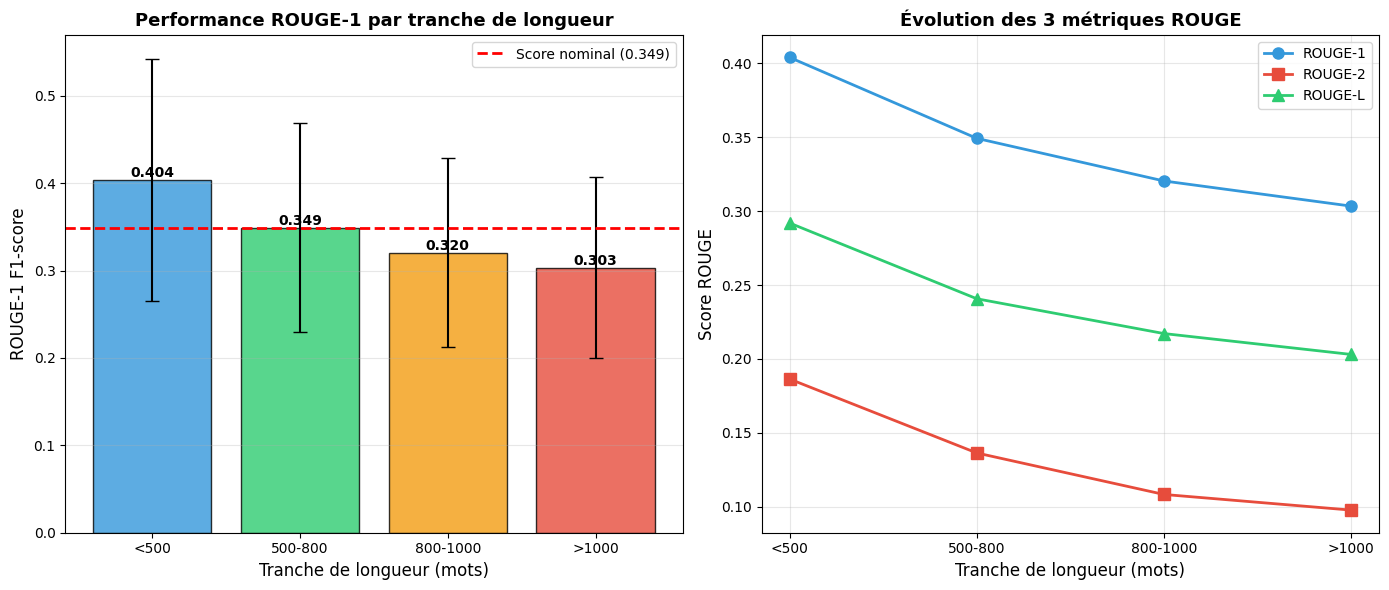


💾 Sauvegarde des résultats...
✅ Fichiers sauvegardés :
  • rouge_by_length_detailed.csv
  • articles_with_length_category.csv
  • rouge_by_length_analysis.png

📋 TABLEAU FORMATÉ POUR LE RAPPORT

```
| Longueur (mots) | % corpus | Articles | ROUGE-1 | Écart vs nominal |
|-----------------|----------|----------|---------|------------------|
| <500            |   30.3%  |      453 | 0.4040  |  +15.8%          |
| 500-800         |   28.0%  |      419 | 0.3493  |   +0.1%          |
| 800-1000        |   15.5%  |      232 | 0.3204  |   -8.2%          |
| >1000           |   26.3%  |      393 | 0.3034  |  -13.0%          |
| NOMINAL         |  100.0%  |     1500 | 0.3489  |    0.0%          |
```

✅ Analyse terminée !

🔬 DIAGNOSTIC AUTOMATIQUE

⚠️  ALERTE : Dégradation significative détectée
   Tranche : >1000
   Dégradation : -13.0%
   Score : 0.3034 (vs 0.3489 nominal)

💡 CAUSE PROBABLE :
   → Troncature T5 à 512 tokens
   → Articles longs perdent ~70% du contenu
   → Solution : Approche 

In [8]:
"""
Analyse ROUGE par tranche de longueur d'article
Pour l'étude d'ablation IT3
"""

import pandas as pd
import numpy as np
from rouge_score import rouge_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

# ==========================================
# CHARGEMENT DES RÉSULTATS T5
# ==========================================

print("📊 ANALYSE ROUGE PAR TRANCHE DE LONGUEUR")
print("="*60)

# Charger les résultats T5 Phase 2
print("\n📂 Chargement des résultats T5...")
results_df = pd.read_pickle(f'{PROJECT_DIR}/results/t5_phase2_final_results.pkl')

print(f"✅ {len(results_df)} résumés chargés")

# Vérifier les colonnes nécessaires
required_cols = ['article', 'highlights', 'generated_summary_t5']
missing_cols = [col for col in required_cols if col not in results_df.columns]

if missing_cols:
    print(f"⚠️  Colonnes manquantes : {missing_cols}")
    print("Assurez-vous d'avoir exécuté l'évaluation T5 Phase 2 complète.")
    raise ValueError("Colonnes manquantes dans les résultats")

# ==========================================
# CALCUL DES LONGUEURS
# ==========================================

print("\n📏 Calcul des longueurs d'articles...")
results_df['article_word_count'] = results_df['article'].apply(lambda x: len(x.split()))

# Définir les tranches
bins = [0, 500, 800, 1000, float('inf')]
labels = ['<500', '500-800', '800-1000', '>1000']

results_df['length_category'] = pd.cut(
    results_df['article_word_count'],
    bins=bins,
    labels=labels
)

# Distribution
distribution = results_df['length_category'].value_counts(normalize=True).sort_index() * 100

print("\n📊 Distribution des longueurs dans l'ensemble évalué:")
print("="*60)
for cat in labels:
    count = (results_df['length_category'] == cat).sum()
    pct = distribution[cat]
    print(f"  {cat:15} : {count:5d} articles ({pct:5.1f}%)")

# ==========================================
# CALCUL ROUGE PAR TRANCHE
# ==========================================

print("\n📊 Calcul des scores ROUGE par tranche...")
print("="*60)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_by_length = {}
detailed_scores = []

for cat in labels:
    subset = results_df[results_df['length_category'] == cat]

    if len(subset) == 0:
        print(f"\n⚠️  Aucun article dans la tranche {cat}")
        continue

    print(f"\n🔍 Tranche {cat} ({len(subset)} articles)...")

    scores_r1 = []
    scores_r2 = []
    scores_rL = []

    for _, row in tqdm(subset.iterrows(), total=len(subset), desc=f"  ROUGE {cat}"):
        # Préparer référence
        if isinstance(row['highlights'], list):
            ref = ' '.join(row['highlights'])
        else:
            ref = row['highlights']

        # Prédiction
        pred = row['generated_summary_t5']

        # Calculer ROUGE
        scores = scorer.score(ref, pred)

        scores_r1.append(scores['rouge1'].fmeasure)
        scores_r2.append(scores['rouge2'].fmeasure)
        scores_rL.append(scores['rougeL'].fmeasure)

    # Moyennes pour cette tranche
    mean_r1 = np.mean(scores_r1)
    mean_r2 = np.mean(scores_r2)
    mean_rL = np.mean(scores_rL)

    std_r1 = np.std(scores_r1)
    std_r2 = np.std(scores_r2)
    std_rL = np.std(scores_rL)

    rouge_by_length[cat] = {
        'rouge1_mean': mean_r1,
        'rouge1_std': std_r1,
        'rouge2_mean': mean_r2,
        'rouge2_std': std_r2,
        'rougeL_mean': mean_rL,
        'rougeL_std': std_rL,
        'n_articles': len(subset)
    }

    detailed_scores.append({
        'length_category': cat,
        'n_articles': len(subset),
        'pct_corpus': distribution[cat],
        'rouge1_mean': mean_r1,
        'rouge1_std': std_r1,
        'rouge2_mean': mean_r2,
        'rouge2_std': std_r2,
        'rougeL_mean': mean_rL,
        'rougeL_std': std_rL
    })

# ==========================================
# AFFICHAGE RÉSULTATS
# ==========================================

print("\n" + "="*70)
print("📊 RÉSULTATS ROUGE PAR TRANCHE DE LONGUEUR")
print("="*70)

# Score nominal (global)
all_r1 = []
all_r2 = []
all_rL = []

for _, row in results_df.iterrows():
    ref = ' '.join(row['highlights']) if isinstance(row['highlights'], list) else row['highlights']
    pred = row['generated_summary_t5']
    scores = scorer.score(ref, pred)
    all_r1.append(scores['rouge1'].fmeasure)
    all_r2.append(scores['rouge2'].fmeasure)
    all_rL.append(scores['rougeL'].fmeasure)

nominal_r1 = np.mean(all_r1)
nominal_r2 = np.mean(all_r2)
nominal_rL = np.mean(all_rL)

print(f"\n📌 Score nominal (global) :")
print(f"  ROUGE-1 : {nominal_r1:.4f}")
print(f"  ROUGE-2 : {nominal_r2:.4f}")
print(f"  ROUGE-L : {nominal_rL:.4f}")

print("\n📋 TABLEAU DÉTAILLÉ PAR TRANCHE")
print("="*70)
print("| Longueur    | % corpus | n    | ROUGE-1      | ROUGE-2      | ROUGE-L      | Écart R1 |")
print("|-------------|----------|------|--------------|--------------|--------------|----------|")

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    pct = distribution[cat]

    # Écart par rapport au nominal
    ecart_r1 = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100

    print(f"| {cat:11} | {pct:6.1f}%  | {data['n_articles']:4d} | "
          f"{data['rouge1_mean']:.4f} ±{data['rouge1_std']:.3f} | "
          f"{data['rouge2_mean']:.4f} ±{data['rouge2_std']:.3f} | "
          f"{data['rougeL_mean']:.4f} ±{data['rougeL_std']:.3f} | "
          f"{ecart_r1:+6.1f}%  |")

print("="*70)

# ==========================================
# ANALYSE DES ÉCARTS
# ==========================================

print("\n📈 ANALYSE DES ÉCARTS PAR RAPPORT AU SCORE NOMINAL")
print("="*70)

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    ecart_r1 = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100
    ecart_r2 = ((data['rouge2_mean'] - nominal_r2) / nominal_r2) * 100

    print(f"\n🔍 Tranche {cat}:")
    print(f"  ROUGE-1 : {data['rouge1_mean']:.4f} ({ecart_r1:+.1f}% vs nominal)")
    print(f"  ROUGE-2 : {data['rouge2_mean']:.4f} ({ecart_r2:+.1f}% vs nominal)")

    if ecart_r1 < -5:
        print(f"  ⚠️  Dégradation significative détectée (>{abs(ecart_r1):.0f}%)")
    elif ecart_r1 > 5:
        print(f"  ✅ Performance supérieure à la moyenne (+{ecart_r1:.0f}%)")
    else:
        print(f"  ℹ️  Performance proche de la moyenne")

# ==========================================
# VISUALISATION
# ==========================================

print("\n📊 Génération des visualisations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1 : ROUGE-1 par tranche avec barres d'erreur
categories = [cat for cat in labels if cat in rouge_by_length]
r1_means = [rouge_by_length[cat]['rouge1_mean'] for cat in categories]
r1_stds = [rouge_by_length[cat]['rouge1_std'] for cat in categories]

x_pos = np.arange(len(categories))
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = axes[0].bar(x_pos, r1_means, yerr=r1_stds, capsize=5,
                   color=colors[:len(categories)], alpha=0.8, edgecolor='black')
axes[0].axhline(nominal_r1, color='red', linestyle='--', linewidth=2,
                label=f'Score nominal ({nominal_r1:.3f})')
axes[0].set_xlabel('Tranche de longueur (mots)', fontsize=12)
axes[0].set_ylabel('ROUGE-1 F1-score', fontsize=12)
axes[0].set_title('Performance ROUGE-1 par tranche de longueur', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Ajouter valeurs sur barres
for i, (bar, val) in enumerate(zip(bars, r1_means)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Graphique 2 : Évolution ROUGE-1, 2, L
r2_means = [rouge_by_length[cat]['rouge2_mean'] for cat in categories]
rL_means = [rouge_by_length[cat]['rougeL_mean'] for cat in categories]

axes[1].plot(categories, r1_means, marker='o', linewidth=2, markersize=8,
            label='ROUGE-1', color='#3498db')
axes[1].plot(categories, r2_means, marker='s', linewidth=2, markersize=8,
            label='ROUGE-2', color='#e74c3c')
axes[1].plot(categories, rL_means, marker='^', linewidth=2, markersize=8,
            label='ROUGE-L', color='#2ecc71')

axes[1].set_xlabel('Tranche de longueur (mots)', fontsize=12)
axes[1].set_ylabel('Score ROUGE', fontsize=12)
axes[1].set_title('Évolution des 3 métriques ROUGE', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rouge_by_length_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : rouge_by_length_analysis.png")
plt.show()

# ==========================================
# SAUVEGARDE DES RÉSULTATS
# ==========================================

print("\n💾 Sauvegarde des résultats...")

# DataFrame détaillé
detailed_df = pd.DataFrame(detailed_scores)
detailed_df.to_csv(f'{PROJECT_DIR}/results/rouge_by_length_detailed.csv', index=False)

# Scores individuels par article (pour analyses supplémentaires)
results_df[['file_id', 'article_word_count', 'length_category']].to_csv(
    f'{PROJECT_DIR}/results/articles_with_length_category.csv', index=False
)

print("✅ Fichiers sauvegardés :")
print("  • rouge_by_length_detailed.csv")
print("  • articles_with_length_category.csv")
print("  • rouge_by_length_analysis.png")

# ==========================================
# TABLEAU POUR LE RAPPORT
# ==========================================

print("\n" + "="*70)
print("📋 TABLEAU FORMATÉ POUR LE RAPPORT")
print("="*70)

print("\n```")
print("| Longueur (mots) | % corpus | Articles | ROUGE-1 | Écart vs nominal |")
print("|-----------------|----------|----------|---------|------------------|")

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    pct = distribution[cat]
    ecart = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100

    print(f"| {cat:15} | {pct:6.1f}%  | {data['n_articles']:8d} | {data['rouge1_mean']:.4f}  | {ecart:+6.1f}%          |")

print(f"| {'NOMINAL':15} | {'100.0':>6}%  | {len(results_df):8d} | {nominal_r1:.4f}  | {'  0.0':>6}%          |")
print("```")

print("\n✅ Analyse terminée !")

# ==========================================
# DIAGNOSTIC AUTOMATIQUE
# ==========================================

print("\n🔬 DIAGNOSTIC AUTOMATIQUE")
print("="*70)

# Identifier la tranche la plus dégradée
worst_cat = None
worst_degradation = 0

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    ecart = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100

    if ecart < worst_degradation:
        worst_degradation = ecart
        worst_cat = cat

if worst_cat and worst_degradation < -5:
    print(f"\n⚠️  ALERTE : Dégradation significative détectée")
    print(f"   Tranche : {worst_cat}")
    print(f"   Dégradation : {worst_degradation:.1f}%")
    print(f"   Score : {rouge_by_length[worst_cat]['rouge1_mean']:.4f} (vs {nominal_r1:.4f} nominal)")
    print(f"\n💡 CAUSE PROBABLE :")

    if worst_cat == '>1000':
        print("   → Troncature T5 à 512 tokens")
        print("   → Articles longs perdent ~70% du contenu")
        print("   → Solution : Approche hybride (IT4)")
    elif worst_cat == '<500':
        print("   → Articles trop courts, peu de contenu à résumer")
        print("   → T5 peut sur-compresser ou manquer de contexte")
else:
    print("\n✅ Aucune dégradation significative détectée")
    print("   Le modèle performe de manière homogène sur toutes les tranches")

## Config et chargement

In [33]:
# ========================================
# ABLATION STUDY - T5 Summarization
# ========================================

import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import Dataset
import pandas as pd
import numpy as np
from rouge_score import rouge_scorer
from tqdm import tqdm
import pickle
import json
from datetime import datetime

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "/content/drive/MyDrive/RCP217_Projet_Summarization/models/t5_small_phase2_final"
TEST_DATA_PATH = "/content/drive/MyDrive/RCP217_Projet_Summarization/test_data.pkl"
RESULTS_DIR = "/content/drive/MyDrive/RCP217_Projet_Summarization/ablation_results"

!mkdir -p {RESULTS_DIR}

# Chargement modèle baseline
print("🔧 Chargement modèle T5 baseline...")
tokenizer = T5Tokenizer.from_pretrained(MODEL_PATH)
model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH).to(DEVICE)
model.eval()

# Chargement données test
print("📂 Chargement test set...")
with open(TEST_DATA_PATH, 'rb') as f:
    test_data_df = pickle.load(f)
    test_data = test_data_df.to_dict('records') # Convert DataFrame to list of dictionaries

# FILTRE : Retirer articles vides
test_data_valid = [d for d in test_data if len(d.get('article', '')) > 0]
print(f"📊 Articles valides : {len(test_data_valid)}/{len(test_data)}")

# Tri par longueur + échantillonnage stratifié (2000 exemples)
test_data_sorted = sorted(test_data_valid, key=lambda x: len(x['article'].split()))
indices = np.linspace(0, len(test_data_sorted)-1, 2000, dtype=int)
test_subset = [test_data_sorted[i] for i in indices]

# Vérifications
print(f"✅ {len(test_subset)} exemples chargés")
print(f"📊 Longueur moyenne : {np.mean([len(d['article'].split()) for d in test_subset]):.0f} mots")
print(f"📊 Article 0 : {len(test_subset[0]['article'])} caractères")
print(f"📊 Article 999 : {len(test_subset[999]['article'])} caractères")

🔧 Chargement modèle T5 baseline...
📂 Chargement test set...
📊 Articles valides : 1497/1500
✅ 2000 exemples chargés
📊 Longueur moyenne : 764 mots
📊 Article 0 : 317 caractères
📊 Article 999 : 3600 caractères


In [34]:
# Exécutez cette cellule
print(f"test_subset existe ? {len(test_subset)}")
print(f"Clés : {test_subset[0].keys()}")
print(f"Article 0 : longueur={len(test_subset[0]['article'])}")
print(f"Highlights 0 : {test_subset[0]['highlights'][:100]}")

# Essayez plusieurs indices
for i in [0, 1, 2, 100, 500]:
    print(f"Article {i} : {len(test_subset[i]['article'])} caractères")

test_subset existe ? 2000
Clés : dict_keys(['article', 'article_sentences', 'highlights', 'num_sentences', 'num_highlights', 'file_id', 'article_length', 'highlights_length', 'avg_sentence_length'])
Article 0 : longueur=317
Highlights 0 : ["The daily transcript is a written version of each day 's CNN Student News program", 'Use this transcript to help students with reading comprehension and vocabulary', 'Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News']
Article 0 : 317 caractères
Article 1 : 317 caractères
Article 2 : 460 caractères
Article 100 : 1398 caractères
Article 500 : 2323 caractères


##Fonction d'évaluation générique

In [35]:
def evaluate_configuration(
    model,
    tokenizer,
    test_data,
    config_name,
    max_source_length=512,
    max_target_length=128,
    num_beams=4,
    length_penalty=1.0,
    preprocessing_fn=None,  # Fonction optionnelle de prétraitement
    batch_size=8
):
    """
    Évalue une configuration spécifique du modèle.

    Args:
        preprocessing_fn: Fonction qui transforme le texte source
                         Signature: fn(article: str) -> str
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    results = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    predictions = []

    print(f"\n🔬 Évaluation: {config_name}")
    print(f"   max_source={max_source_length}, max_target={max_target_length}")
    print(f"   beams={num_beams}, length_penalty={length_penalty}")

    for i in tqdm(range(0, len(test_data), batch_size), desc="Batch"):
        batch = test_data[i:i+batch_size]

        # Prétraitement optionnel
        if preprocessing_fn:
            articles = [preprocessing_fn(d['article']) for d in batch]
        else:
            articles = [d['article'] for d in batch]

        # Préfixe T5
        inputs = [f"summarize: {art}" for art in articles]

        # Tokenization
        encoded = tokenizer(
            inputs,
            max_length=max_source_length,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(DEVICE)

        # Génération
        with torch.no_grad():
            outputs = model.generate(
                **encoded,
                max_length=max_target_length,
                num_beams=num_beams,
                length_penalty=length_penalty,
                early_stopping=True,
                no_repeat_ngram_size=3  # Garde constant pour comparabilité
            )

        # Décodage
        summaries = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # ROUGE
        for j, summary in enumerate(summaries):
            reference = "\n".join(batch[j]['highlights']) # Join the list of highlights into a single string
            scores = scorer.score(reference, summary)

            results['rouge1'].append(scores['rouge1'].fmeasure)
            results['rouge2'].append(scores['rouge2'].fmeasure)
            results['rougeL'].append(scores['rougeL'].fmeasure)

            predictions.append({
                'article': batch[j]['article'][:200],  # Tronqué pour sauvegarde
                'reference': reference,
                'prediction': summary,
                'rouge1': scores['rouge1'].fmeasure
            })

    # Agrégation
    final_scores = {
        'config_name': config_name,
        'rouge1_mean': np.mean(results['rouge1']),
        'rouge1_std': np.std(results['rouge1']),
        'rouge2_mean': np.mean(results['rouge2']),
        'rouge2_std': np.std(results['rouge2']),
        'rougeL_mean': np.mean(results['rougeL']),
        'rougeL_std': np.std(results['rougeL']),
        'n_samples': len(results['rouge1'])
    }

    return final_scores, predictions

# Test baseline
baseline_scores, baseline_preds = evaluate_configuration(
    model, tokenizer, test_subset,
    config_name="BASELINE",
    max_source_length=512,
    max_target_length=128,
    num_beams=4,
    length_penalty=1.0
)

print(f"\n📊 BASELINE RESULTS:")
print(f"   ROUGE-1: {baseline_scores['rouge1_mean']:.4f} ± {baseline_scores['rouge1_std']:.4f}")
print(f"   ROUGE-2: {baseline_scores['rouge2_mean']:.4f} ± {baseline_scores['rouge2_std']:.4f}")
print(f"   ROUGE-L: {baseline_scores['rougeL_mean']:.4f} ± {baseline_scores['rougeL_std']:.4f}")


🔬 Évaluation: BASELINE
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:56<00:00,  1.90s/it]


📊 BASELINE RESULTS:
   ROUGE-1: 0.3439 ± 0.1238
   ROUGE-2: 0.1353 ± 0.1230
   ROUGE-L: 0.2387 ± 0.1155


##Ablation A1 - Longueur d'entrée

In [36]:
print("\n" + "="*60)
print("ABLATION A1 - Impact de max_source_length")
print("="*60)

a1_results = [baseline_scores]  # Inclut baseline (512)

for source_len in [256, 384, 768]:
    scores, _ = evaluate_configuration(
        model, tokenizer, test_subset,
        config_name=f"A1_source_{source_len}",
        max_source_length=source_len,
        max_target_length=128,
        num_beams=4,
        length_penalty=1.0
    )
    a1_results.append(scores)

# Sauvegarde
pd.DataFrame(a1_results).to_csv(f"{RESULTS_DIR}/a1_source_length.csv", index=False)


ABLATION A1 - Impact de max_source_length

🔬 Évaluation: A1_source_256
   max_source=256, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [06:32<00:00,  1.57s/it]



🔬 Évaluation: A1_source_384
   max_source=384, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:17<00:00,  1.75s/it]



🔬 Évaluation: A1_source_768
   max_source=768, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [09:07<00:00,  2.19s/it]


##Ablation A2 - Longueur de sortie

In [37]:
print("\n" + "="*60)
print("ABLATION A2 - Impact de max_target_length")
print("="*60)

a2_results = [baseline_scores]

for target_len in [64, 96, 192]:
    scores, _ = evaluate_configuration(
        model, tokenizer, test_subset,
        config_name=f"A2_target_{target_len}",
        max_source_length=512,
        max_target_length=target_len,
        num_beams=4,
        length_penalty=1.0
    )
    a2_results.append(scores)

pd.DataFrame(a2_results).to_csv(f"{RESULTS_DIR}/a2_target_length.csv", index=False)


ABLATION A2 - Impact de max_target_length

🔬 Évaluation: A2_target_64
   max_source=512, max_target=64
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [05:47<00:00,  1.39s/it]



🔬 Évaluation: A2_target_96
   max_source=512, max_target=96
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:43<00:00,  1.85s/it]



🔬 Évaluation: A2_target_192
   max_source=512, max_target=192
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:54<00:00,  1.90s/it]


##Ablation A3 - Beam search

In [38]:
print("\n" + "="*60)
print("ABLATION A3 - Impact du nombre de beams")
print("="*60)

a3_results = [baseline_scores]

for n_beams in [1, 2, 6, 8]:  # 1 = greedy decoding
    scores, _ = evaluate_configuration(
        model, tokenizer, test_subset,
        config_name=f"A3_beams_{n_beams}",
        max_source_length=512,
        max_target_length=128,
        num_beams=n_beams,
        length_penalty=1.0
    )
    a3_results.append(scores)

pd.DataFrame(a3_results).to_csv(f"{RESULTS_DIR}/a3_beam_search.csv", index=False)


ABLATION A3 - Impact du nombre de beams

🔬 Évaluation: A3_beams_1
   max_source=512, max_target=128
   beams=1, length_penalty=1.0


Batch: 100%|██████████| 250/250 [05:05<00:00,  1.22s/it]



🔬 Évaluation: A3_beams_2
   max_source=512, max_target=128
   beams=2, length_penalty=1.0


Batch: 100%|██████████| 250/250 [06:25<00:00,  1.54s/it]



🔬 Évaluation: A3_beams_6
   max_source=512, max_target=128
   beams=6, length_penalty=1.0


Batch: 100%|██████████| 250/250 [09:24<00:00,  2.26s/it]



🔬 Évaluation: A3_beams_8
   max_source=512, max_target=128
   beams=8, length_penalty=1.0


Batch: 100%|██████████| 250/250 [11:23<00:00,  2.73s/it]


##Ablation A4 - Length penalty

In [39]:
print("\n" + "="*60)
print("ABLATION A4 - Impact de length_penalty")
print("="*60)

a4_results = [baseline_scores]

for penalty in [0.5, 1.5, 2.0]:
    scores, _ = evaluate_configuration(
        model, tokenizer, test_subset,
        config_name=f"A4_penalty_{penalty}",
        max_source_length=512,
        max_target_length=128,
        num_beams=4,
        length_penalty=penalty
    )
    a4_results.append(scores)

pd.DataFrame(a4_results).to_csv(f"{RESULTS_DIR}/a4_length_penalty.csv", index=False)


ABLATION A4 - Impact de length_penalty

🔬 Évaluation: A4_penalty_0.5
   max_source=512, max_target=128
   beams=4, length_penalty=0.5


Batch: 100%|██████████| 250/250 [07:56<00:00,  1.91s/it]



🔬 Évaluation: A4_penalty_1.5
   max_source=512, max_target=128
   beams=4, length_penalty=1.5


Batch: 100%|██████████| 250/250 [07:46<00:00,  1.86s/it]



🔬 Évaluation: A4_penalty_2.0
   max_source=512, max_target=128
   beams=4, length_penalty=2.0


Batch: 100%|██████████| 250/250 [07:43<00:00,  1.85s/it]


##Ablation A5 - Prétraitement structure

In [40]:
print("\n" + "="*60)
print("ABLATION A5 - Impact du prétraitement structurel")
print("="*60)

# Fonction 1 : Sans structure (tout en un bloc)
def preprocess_no_structure(article):
    sentences = article.split('\n')
    return ' '.join([s.strip() for s in sentences if s.strip()])

# Fonction 2 : Avec séparateurs <SEP>
def preprocess_with_sep(article):
    sentences = article.split('\n')
    return ' <SEP> '.join([s.strip() for s in sentences if s.strip()])

# Fonction 3 : Avec numérotation
def preprocess_with_numbering(article):
    sentences = article.split('\n')
    numbered = [f"[{i+1}] {s.strip()}" for i, s in enumerate(sentences) if s.strip()]
    return ' '.join(numbered)

a5_results = [baseline_scores]  # Baseline = structure naturelle avec \n

# Test 1 : Sans structure
scores_no_struct, _ = evaluate_configuration(
    model, tokenizer, test_subset,
    config_name="A5_no_structure",
    max_source_length=512,
    max_target_length=128,
    num_beams=4,
    length_penalty=1.0,
    preprocessing_fn=preprocess_no_structure
)
a5_results.append(scores_no_struct)

# Test 2 : Avec <SEP>
scores_sep, _ = evaluate_configuration(
    model, tokenizer, test_subset,
    config_name="A5_with_SEP",
    max_source_length=512,
    max_target_length=128,
    num_beams=4,
    length_penalty=1.0,
    preprocessing_fn=preprocess_with_sep
)
a5_results.append(scores_sep)

# Test 3 : Avec numérotation
scores_num, _ = evaluate_configuration(
    model, tokenizer, test_subset,
    config_name="A5_numbered",
    max_source_length=512,
    max_target_length=128,
    num_beams=4,
    length_penalty=1.0,
    preprocessing_fn=preprocess_with_numbering
)
a5_results.append(scores_num)

pd.DataFrame(a5_results).to_csv(f"{RESULTS_DIR}/a5_preprocessing.csv", index=False)

# Affichage comparatif
print("\n📊 RÉSULTATS A5 - Prétraitement structurel:")
print("-" * 80)
for result in a5_results:
    delta = ((result['rouge1_mean'] - baseline_scores['rouge1_mean']) / baseline_scores['rouge1_mean']) * 100
    print(f"{result['config_name']:25s} | ROUGE-1: {result['rouge1_mean']:.4f} | Δ: {delta:+.2f}%")
print("-" * 80)


ABLATION A5 - Impact du prétraitement structurel

🔬 Évaluation: A5_no_structure
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:43<00:00,  1.85s/it]



🔬 Évaluation: A5_with_SEP
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:42<00:00,  1.85s/it]



🔬 Évaluation: A5_numbered
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:41<00:00,  1.85s/it]


📊 RÉSULTATS A5 - Prétraitement structurel:
--------------------------------------------------------------------------------
BASELINE                  | ROUGE-1: 0.3439 | Δ: +0.00%
A5_no_structure           | ROUGE-1: 0.3439 | Δ: +0.00%
A5_with_SEP               | ROUGE-1: 0.3439 | Δ: +0.00%
A5_numbered               | ROUGE-1: 0.3443 | Δ: +0.10%
--------------------------------------------------------------------------------


##A6 - Pré-extraction + T5

In [41]:
# ABLATION A6 - Pré-extraction + T5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def textrank_scores(sentences):
    if not sentences:
        return []

    vectorizer = TfidfVectorizer(stop_words='english')
    try:
        tfidf_matrix = vectorizer.fit_transform(sentences)
    except ValueError:
        return [0.0] * len(sentences)

    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    scores = np.sum(similarity_matrix, axis=1)
    return scores.tolist()

def preprocess_hybrid_extractive(article, top_n=10):
    sentences = [s.strip() for s in article.split('\n') if s.strip()]

    if not sentences:
        return ""

    scores = textrank_scores(sentences)
    ranked = sorted(zip(sentences, scores), key=lambda x: x[1], reverse=True)
    top_sentences_extracted = [s for s, _ in ranked[:top_n]]

    original_sentences_map = {s: i for i, s in enumerate(sentences)}
    top_sentences_ordered = sorted([s for s in top_sentences_extracted if s in original_sentences_map],
                                   key=lambda s: original_sentences_map[s])

    return '\n'.join(top_sentences_ordered)

# AJOUT : Liste pour stocker résultats
a6_results = [baseline_scores]

# Évaluation sur plusieurs top_n
for top_n in [5, 10, 15, 20]:
    scores, _ = evaluate_configuration(
        model, tokenizer, test_subset,
        config_name=f"A6_hybrid_top{top_n}",  # ← Nom dynamique
        max_source_length=512,
        max_target_length=128,
        num_beams=4,
        length_penalty=1.0,
        preprocessing_fn=lambda x, n=top_n: preprocess_hybrid_extractive(x, top_n=n)
    )
    a6_results.append(scores)

# SAUVEGARDE
pd.DataFrame(a6_results).to_csv(f"{RESULTS_DIR}/a6_hybrid_approach.csv", index=False)
print(f"✅ A6 sauvegardé : {RESULTS_DIR}/a6_hybrid_approach.csv")


🔬 Évaluation: A6_hybrid_top5
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:51<00:00,  1.89s/it]



🔬 Évaluation: A6_hybrid_top10
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:49<00:00,  1.88s/it]



🔬 Évaluation: A6_hybrid_top15
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [07:48<00:00,  1.87s/it]



🔬 Évaluation: A6_hybrid_top20
   max_source=512, max_target=128
   beams=4, length_penalty=1.0


Batch: 100%|██████████| 250/250 [08:04<00:00,  1.94s/it]

✅ A6 sauvegardé : /content/drive/MyDrive/RCP217_Projet_Summarization/ablation_results/a6_hybrid_approach.csv


In [42]:
# Test manuel
article_test = test_subset[0]['article']
print(f"Phrases originales : {len(article_test.split(chr(10)))}")

hybrid_5 = preprocess_hybrid_extractive(article_test, top_n=5)
hybrid_10 = preprocess_hybrid_extractive(article_test, top_n=10)

print(f"Hybrid top5  : {len(hybrid_5.split(chr(10)))} phrases")
print(f"Hybrid top10 : {len(hybrid_10.split(chr(10)))} phrases")
phrase_counts = [len(d['article'].split('\n')) for d in test_subset]
print(f"Distribution phrases : {np.percentile(phrase_counts, [25, 50, 75, 90])}")

Phrases originales : 1
Hybrid top5  : 1 phrases
Hybrid top10 : 1 phrases
Distribution phrases : [1. 1. 1. 1.]


In [43]:
# Afficher l'article brut
article = test_subset[0]['article']
print(f"Longueur : {len(article)} caractères")
print(f"Aperçu : {article[:500]}")
print(f"Contient \\n ? {repr(article[:200])}")  # Montre les \n échappés

Longueur : 317 caractères
Aperçu : -LRB- CNN Student News -RRB- -- November 18 , 2011 Download PDF maps related to today 's show : New York City Azerbaijan Click here to access the transcript of today 's CNN Student News program . Please note that there may be a delay between the time when the video is available and when the transcript is published .
Contient \n ? "-LRB- CNN Student News -RRB- -- November 18 , 2011 Download PDF maps related to today 's show : New York City Azerbaijan Click here to access the transcript of today 's CNN Student News program . Plea"


## Analyse de correlation

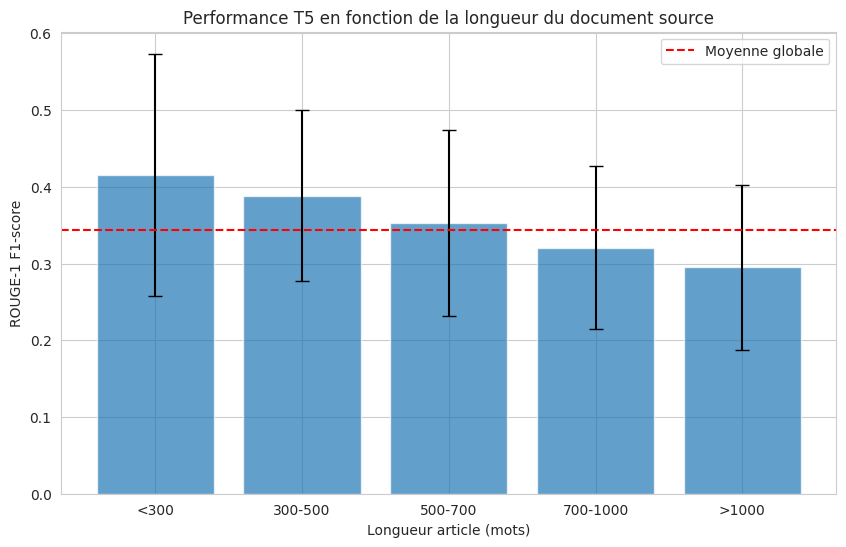

              mean       std      n
<300      0.415754  0.157630  205.0
300-500   0.388405  0.111446  399.0
500-700   0.352893  0.121701  400.0
700-1000  0.320512  0.106077  469.0
>1000     0.295310  0.107391  520.0


In [44]:
import matplotlib.pyplot as plt

# Charger résultats baseline
# The original line was trying to load results from a .pkl file which resulted in a KeyError.
# We will use the 'baseline_preds' variable which already contains the detailed scores
# generated from the 'evaluate_configuration' function.
# with open(f"{RESULTS_DIR}/../results/t5_phase2_final_results.pkl", 'rb') as f:
#     results = pickle.load(f)

# Analyser corrélation longueur article → performance
article_lengths = [len(d['article'].split()) for d in test_subset]
# Use baseline_preds directly to get rouge1 scores
rouge_scores = [r['rouge1'] for r in baseline_preds[:len(test_subset)]]

# Binning par longueur
bins = [0, 300, 500, 700, 1000, 2000]
bin_labels = ['<300', '300-500', '500-700', '700-1000', '>1000']

performance_by_length = {}
for bin_start, bin_end, label in zip(bins[:-1], bins[1:], bin_labels):
    mask = [(l >= bin_start and l < bin_end) for l in article_lengths]
    scores_in_bin = [s for s, m in zip(rouge_scores, mask) if m]
    # Handle cases where a bin might be empty
    if scores_in_bin:
        performance_by_length[label] = {
            'mean': np.mean(scores_in_bin),
            'std': np.std(scores_in_bin),
            'n': len(scores_in_bin)
        }
    else:
        performance_by_length[label] = {
            'mean': np.nan, # Use NaN for empty bins
            'std': np.nan,
            'n': 0
        }

# Visualisation
plt.figure(figsize=(10, 6))
labels = list(performance_by_length.keys())
means = [performance_by_length[l]['mean'] for l in labels]
stds = [performance_by_length[l]['std'] for l in labels]

plt.bar(labels, means, yerr=stds, capsize=5, alpha=0.7)
plt.axhline(y=baseline_scores['rouge1_mean'], color='red', linestyle='--', label='Moyenne globale')
plt.xlabel('Longueur article (mots)')
plt.ylabel('ROUGE-1 F1-score')
plt.title('Performance T5 en fonction de la longueur du document source')
plt.legend()
plt.savefig(f"{RESULTS_DIR}/performance_vs_length.png", dpi=300)
plt.show()

# Tableau pour rapport
df_length = pd.DataFrame(performance_by_length).T
print(df_length)


In [6]:
#!pip install rouge-score -q

import pandas as pd
import numpy as np
from rouge_score import rouge_scorer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================

PROJECT_DIR = '/content/drive/MyDrive/RCP217_Projet_Summarization'

# ==========================================
# CHARGEMENT DES RÉSULTATS T5
# ==========================================

print("📊 ANALYSE ROUGE PAR TRANCHE DE LONGUEUR")
print("="*60)

# Charger les résultats T5 Phase 2
print("\n📂 Chargement des résultats T5...")
results_df = pd.read_pickle(f'{PROJECT_DIR}/results/t5_phase2_final_results.pkl')

print(f"✅ {len(results_df)} résumés chargés")

# Vérifier les colonnes nécessaires
required_cols = ['article', 'highlights', 'generated_summary_t5']
missing_cols = [col for col in required_cols if col not in results_df.columns]

if missing_cols:
    print(f"⚠️  Colonnes manquantes : {missing_cols}")
    print("Assurez-vous d'avoir exécuté l'évaluation T5 Phase 2 complète.")
    raise ValueError("Colonnes manquantes dans les résultats")

# ==========================================
# CALCUL DES LONGUEURS
# ==========================================

print("\n📏 Calcul des longueurs d'articles...")
results_df['article_word_count'] = results_df['article'].apply(lambda x: len(x.split()))

# Définir les tranches
bins = [0, 500, 800, 1000, float('inf')]
labels = ['<500', '500-800', '800-1000', '>1000']

results_df['length_category'] = pd.cut(
    results_df['article_word_count'],
    bins=bins,
    labels=labels
)

# Distribution
distribution = results_df['length_category'].value_counts(normalize=True).sort_index() * 100

print("\n📊 Distribution des longueurs dans l'ensemble évalué:")
print("="*60)
for cat in labels:
    count = (results_df['length_category'] == cat).sum()
    pct = distribution[cat]
    print(f"  {cat:15} : {count:5d} articles ({pct:5.1f}%)")

# ==========================================
# CALCUL ROUGE PAR TRANCHE
# ==========================================

print("\n📊 Calcul des scores ROUGE par tranche...")
print("="*60)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_by_length = {}
detailed_scores = []

for cat in labels:
    subset = results_df[results_df['length_category'] == cat]

    if len(subset) == 0:
        print(f"\n⚠️  Aucun article dans la tranche {cat}")
        continue

    print(f"\n🔍 Tranche {cat} ({len(subset)} articles)...")

    scores_r1 = []
    scores_r2 = []
    scores_rL = []

    for _, row in tqdm(subset.iterrows(), total=len(subset), desc=f"  ROUGE {cat}"):
        # Préparer référence
        if isinstance(row['highlights'], list):
            ref = ' '.join(row['highlights'])
        else:
            ref = row['highlights']

        # Prédiction
        pred = row['generated_summary_t5']

        # Calculer ROUGE
        scores = scorer.score(ref, pred)

        scores_r1.append(scores['rouge1'].fmeasure)
        scores_r2.append(scores['rouge2'].fmeasure)
        scores_rL.append(scores['rougeL'].fmeasure)

    # Moyennes pour cette tranche
    mean_r1 = np.mean(scores_r1)
    mean_r2 = np.mean(scores_r2)
    mean_rL = np.mean(scores_rL)

    std_r1 = np.std(scores_r1)
    std_r2 = np.std(scores_r2)
    std_rL = np.std(scores_rL)

    rouge_by_length[cat] = {
        'rouge1_mean': mean_r1,
        'rouge1_std': std_r1,
        'rouge2_mean': mean_r2,
        'rouge2_std': std_r2,
        'rougeL_mean': mean_rL,
        'rougeL_std': std_rL,
        'n_articles': len(subset)
    }

    detailed_scores.append({
        'length_category': cat,
        'n_articles': len(subset),
        'pct_corpus': distribution[cat],
        'rouge1_mean': mean_r1,
        'rouge1_std': std_r1,
        'rouge2_mean': mean_r2,
        'rouge2_std': std_r2,
        'rougeL_mean': mean_rL,
        'rougeL_std': std_rL
    })

# ==========================================
# AFFICHAGE RÉSULTATS
# ==========================================

print("\n" + "="*70)
print("📊 RÉSULTATS ROUGE PAR TRANCHE DE LONGUEUR")
print("="*70)

# Score nominal (global)
all_r1 = []
all_r2 = []
all_rL = []

for _, row in results_df.iterrows():
    ref = ' '.join(row['highlights']) if isinstance(row['highlights'], list) else row['highlights']
    pred = row['generated_summary_t5']
    scores = scorer.score(ref, pred)
    all_r1.append(scores['rouge1'].fmeasure)
    all_r2.append(scores['rouge2'].fmeasure)
    all_rL.append(scores['rougeL'].fmeasure)

nominal_r1 = np.mean(all_r1)
nominal_r2 = np.mean(all_r2)
nominal_rL = np.mean(all_rL)

print(f"\n📌 Score nominal (global) :")
print(f"  ROUGE-1 : {nominal_r1:.4f}")
print(f"  ROUGE-2 : {nominal_r2:.4f}")
print(f"  ROUGE-L : {nominal_rL:.4f}")

print("\n📋 TABLEAU DÉTAILLÉ PAR TRANCHE")
print("="*70)
print("| Longueur    | % corpus | n    | ROUGE-1      | ROUGE-2      | ROUGE-L      | Écart R1 |")
print("|-------------|----------|------|--------------|--------------|--------------|----------|")

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    pct = distribution[cat]

    # Écart par rapport au nominal
    ecart_r1 = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100

    print(f"| {cat:11} | {pct:6.1f}%  | {data['n_articles']:4d} | "
          f"{data['rouge1_mean']:.4f} ±{data['rouge1_std']:.3f} | "
          f"{data['rouge2_mean']:.4f} ±{data['rouge2_std']:.3f} | "
          f"{data['rougeL_mean']:.4f} ±{data['rougeL_std']:.3f} | "
          f"{ecart_r1:+6.1f}%  |")

print("="*70)

# ==========================================
# ANALYSE DES ÉCARTS
# ==========================================

print("\n📈 ANALYSE DES ÉCARTS PAR RAPPORT AU SCORE NOMINAL")
print("="*70)

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    ecart_r1 = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100
    ecart_r2 = ((data['rouge2_mean'] - nominal_r2) / nominal_r2) * 100

    print(f"\n🔍 Tranche {cat}:")
    print(f"  ROUGE-1 : {data['rouge1_mean']:.4f} ({ecart_r1:+.1f}% vs nominal)")
    print(f"  ROUGE-2 : {data['rouge2_mean']:.4f} ({ecart_r2:+.1f}% vs nominal)")

    if ecart_r1 < -5:
        print(f"  ⚠️  Dégradation significative détectée (>{abs(ecart_r1):.0f}%)")
    elif ecart_r1 > 5:
        print(f"  ✅ Performance supérieure à la moyenne (+{ecart_r1:.0f}%)")
    else:
        print(f"  ℹ️  Performance proche de la moyenne")

# ==========================================
# VISUALISATION
# ==========================================

print("\n📊 Génération des visualisations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1 : ROUGE-1 par tranche avec barres d'erreur
categories = [cat for cat in labels if cat in rouge_by_length]
r1_means = [rouge_by_length[cat]['rouge1_mean'] for cat in categories]
r1_stds = [rouge_by_length[cat]['rouge1_std'] for cat in categories]

x_pos = np.arange(len(categories))
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

bars = axes[0].bar(x_pos, r1_means, yerr=r1_stds, capsize=5,
                   color=colors[:len(categories)], alpha=0.8, edgecolor='black')
axes[0].axhline(nominal_r1, color='red', linestyle='--', linewidth=2,
                label=f'Score nominal ({nominal_r1:.3f})')
axes[0].set_xlabel('Tranche de longueur (mots)', fontsize=12)
axes[0].set_ylabel('ROUGE-1 F1-score', fontsize=12)
axes[0].set_title('Performance ROUGE-1 par tranche de longueur', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Ajouter valeurs sur barres
for i, (bar, val) in enumerate(zip(bars, r1_means)):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Graphique 2 : Évolution ROUGE-1, 2, L
r2_means = [rouge_by_length[cat]['rouge2_mean'] for cat in categories]
rL_means = [rouge_by_length[cat]['rougeL_mean'] for cat in categories]

axes[1].plot(categories, r1_means, marker='o', linewidth=2, markersize=8,
            label='ROUGE-1', color='#3498db')
axes[1].plot(categories, r2_means, marker='s', linewidth=2, markersize=8,
            label='ROUGE-2', color='#e74c3c')
axes[1].plot(categories, rL_means, marker='^', linewidth=2, markersize=8,
            label='ROUGE-L', color='#2ecc71')

axes[1].set_xlabel('Tranche de longueur (mots)', fontsize=12)
axes[1].set_ylabel('Score ROUGE', fontsize=12)
axes[1].set_title('Évolution des 3 métriques ROUGE', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rouge_by_length_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé : rouge_by_length_analysis.png")
plt.show()

# ==========================================
# SAUVEGARDE DES RÉSULTATS
# ==========================================

print("\n💾 Sauvegarde des résultats...")

# DataFrame détaillé
detailed_df = pd.DataFrame(detailed_scores)
detailed_df.to_csv(f'{PROJECT_DIR}/results/rouge_by_length_detailed.csv', index=False)

# Scores individuels par article (pour analyses supplémentaires)
results_df[['file_id', 'article_word_count', 'length_category']].to_csv(
    f'{PROJECT_DIR}/results/articles_with_length_category.csv', index=False
)

print("✅ Fichiers sauvegardés :")
print("  • rouge_by_length_detailed.csv")
print("  • articles_with_length_category.csv")
print("  • rouge_by_length_analysis.png")

# ==========================================
# TABLEAU POUR LE RAPPORT
# ==========================================

print("\n" + "="*70)
print("📋 TABLEAU FORMATÉ POUR LE RAPPORT")
print("="*70)

print("\n```")
print("| Longueur (mots) | % corpus | Articles | ROUGE-1 | Écart vs nominal |")
print("|-----------------|----------|----------|---------|------------------|")

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    pct = distribution[cat]
    ecart = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100

    print(f"| {cat:15} | {pct:6.1f}%  | {data['n_articles']:8d} | {data['rouge1_mean']:.4f}  | {ecart:+6.1f}%          |")

print(f"| {'NOMINAL':15} | {'100.0':>6}%  | {len(results_df):8d} | {nominal_r1:.4f}  | {'  0.0':>6}%          |")
print("```")

print("\n✅ Analyse terminée !")

# ==========================================
# DIAGNOSTIC AUTOMATIQUE
# ==========================================

print("\n🔬 DIAGNOSTIC AUTOMATIQUE")
print("="*70)

# Identifier la tranche la plus dégradée
worst_cat = None
worst_degradation = 0

for cat in labels:
    if cat not in rouge_by_length:
        continue

    data = rouge_by_length[cat]
    ecart = ((data['rouge1_mean'] - nominal_r1) / nominal_r1) * 100

    if ecart < worst_degradation:
        worst_degradation = ecart
        worst_cat = cat

if worst_cat and worst_degradation < -5:
    print(f"\n⚠️  ALERTE : Dégradation significative détectée")
    print(f"   Tranche : {worst_cat}")
    print(f"   Dégradation : {worst_degradation:.1f}%")
    print(f"   Score : {rouge_by_length[worst_cat]['rouge1_mean']:.4f} (vs {nominal_r1:.4f} nominal)")
    print(f"\n💡 CAUSE PROBABLE :")

    if worst_cat == '>1000':
        print("   → Troncature T5 à 512 tokens")
        print("   → Articles longs perdent ~70% du contenu")
        print("   → Solution : Approche hybride (IT4)")
    elif worst_cat == '<500':
        print("   → Articles trop courts, peu de contenu à résumer")
        print("   → T5 peut sur-compresser ou manquer de contexte")
else:
    print("\n✅ Aucune dégradation significative détectée")
    print("   Le modèle performe de manière homogène sur toutes les tranches")

ModuleNotFoundError: No module named 'rouge_score'

##Visualisation et analyse

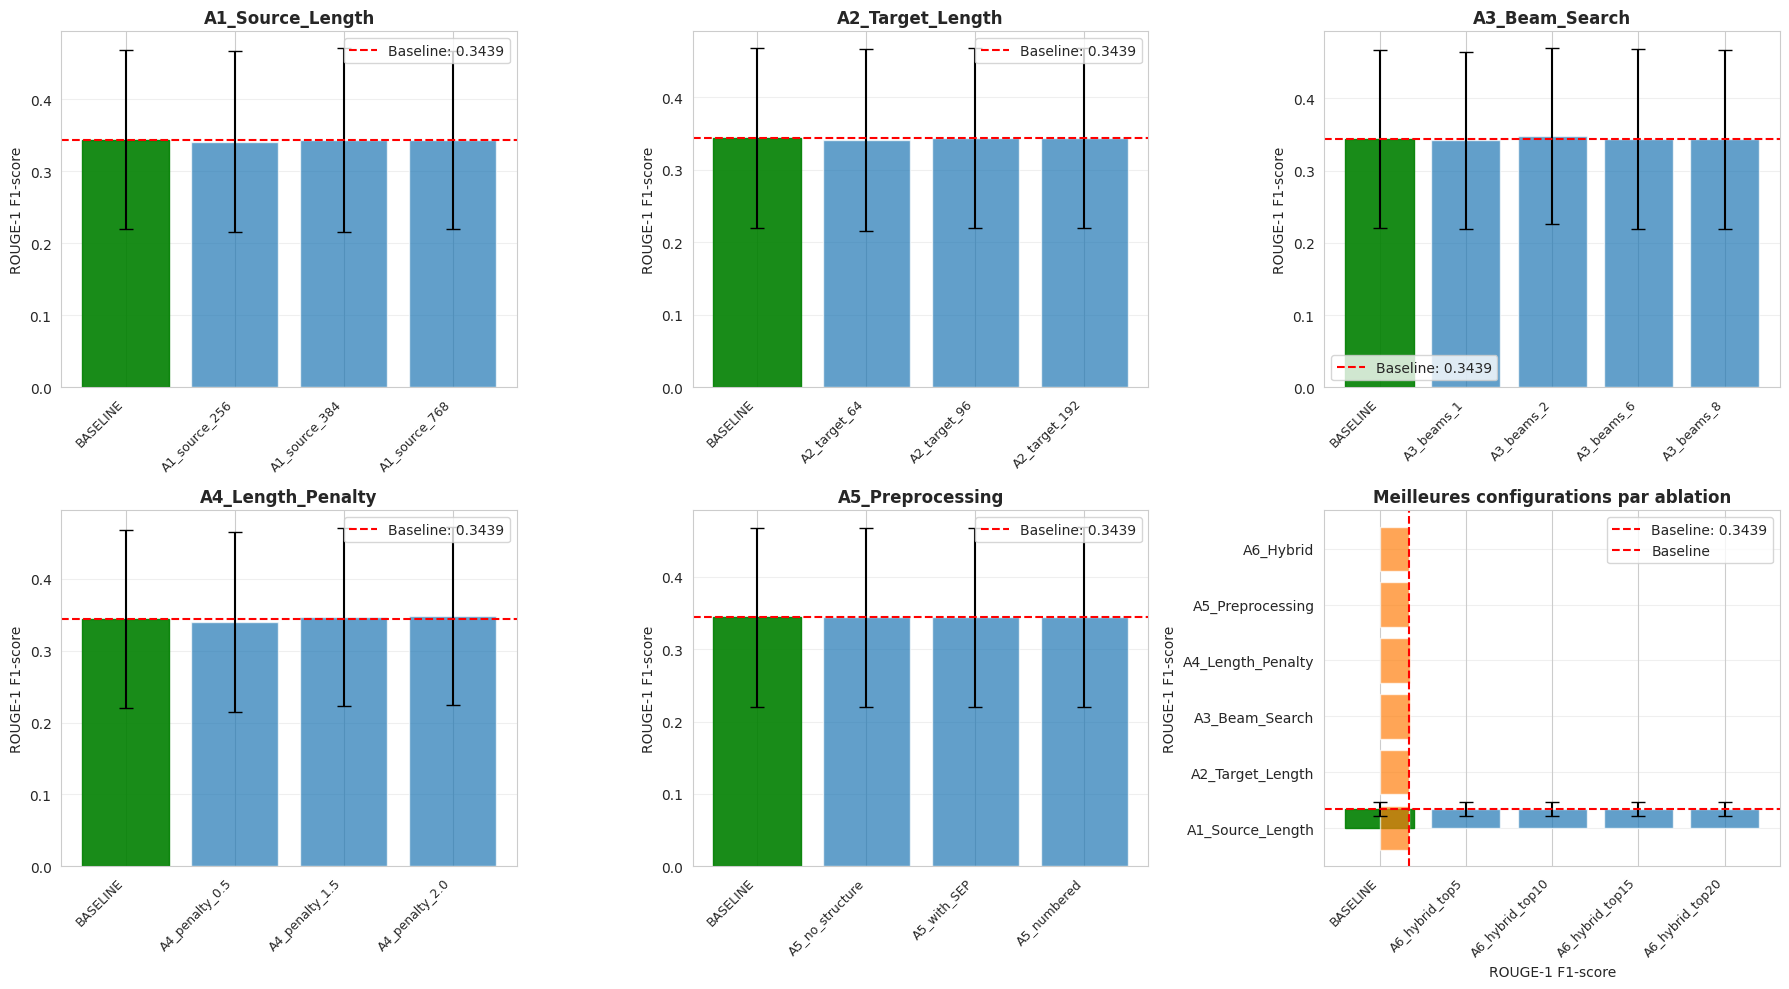


✅ Visualisations sauvegardées!


In [45]:
# ========================================
# VISUALISATION DES RÉSULTATS
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Chargement de TOUS les résultats (A1 à A6)
all_ablations = {
    'A1_Source_Length': pd.read_csv(f"{RESULTS_DIR}/a1_source_length.csv"),
    'A2_Target_Length': pd.read_csv(f"{RESULTS_DIR}/a2_target_length.csv"),
    'A3_Beam_Search': pd.read_csv(f"{RESULTS_DIR}/a3_beam_search.csv"),
    'A4_Length_Penalty': pd.read_csv(f"{RESULTS_DIR}/a4_length_penalty.csv"),
    'A5_Preprocessing': pd.read_csv(f"{RESULTS_DIR}/a5_preprocessing.csv"),
    'A6_Hybrid': pd.read_csv(f"{RESULTS_DIR}/a6_hybrid_approach.csv")  # ← AJOUTÉ
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 6 subplots (A1-A6)

axes = axes.flatten()

for idx, (name, df) in enumerate(all_ablations.items()):
    ax = axes[idx]

    # Extraction valeur baseline
    baseline_r1 = baseline_scores['rouge1_mean']

    # Plot
    x_labels = df['config_name'].tolist()
    rouge1_values = df['rouge1_mean'].tolist()
    rouge1_std = df['rouge1_std'].tolist()

    bars = ax.bar(range(len(x_labels)), rouge1_values,
                   yerr=rouge1_std, capsize=5, alpha=0.7)

    # Colorer baseline différemment
    bars[0].set_color('green')
    bars[0].set_alpha(0.9)

    # Ligne de baseline
    ax.axhline(y=baseline_r1, color='red', linestyle='--',
               label=f'Baseline: {baseline_r1:.4f}')

    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('ROUGE-1 F1-score')
    ax.set_title(name, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Dernière subplot: Comparaison globale des meilleures configs
ax = axes[5]
best_configs = []
for name, df in all_ablations.items():
    best_row = df.loc[df['rouge1_mean'].idxmax()]
    best_configs.append({
        'Ablation': name,
        'ROUGE-1': best_row['rouge1_mean'],
        'Config': best_row['config_name']
    })

best_df = pd.DataFrame(best_configs)
ax.barh(best_df['Ablation'], best_df['ROUGE-1'], alpha=0.7)
ax.axvline(x=baseline_r1, color='red', linestyle='--', label='Baseline')
ax.set_xlabel('ROUGE-1 F1-score')
ax.set_title('Meilleures configurations par ablation', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/ablation_study_summary.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualisations sauvegardées!")

#Rapport statistique

In [46]:
# ========================================
# ANALYSE STATISTIQUE
# ========================================

def compute_relative_change(baseline_val, new_val):
    """Calcule changement relatif en %"""
    return ((new_val - baseline_val) / baseline_val) * 100

# Génération tableau récapitulatif
summary_rows = []

for ablation_name, df in all_ablations.items():
    for _, row in df.iterrows():
        if row['config_name'] == 'BASELINE':
            continue

        delta_r1 = compute_relative_change(baseline_scores['rouge1_mean'], row['rouge1_mean'])
        delta_r2 = compute_relative_change(baseline_scores['rouge2_mean'], row['rouge2_mean'])
        delta_rL = compute_relative_change(baseline_scores['rougeL_mean'], row['rougeL_mean'])

        summary_rows.append({
            'Ablation': ablation_name,
            'Configuration': row['config_name'],
            'ROUGE-1': f"{row['rouge1_mean']:.4f}",
            'Δ R-1 (%)': f"{delta_r1:+.2f}%",
            'ROUGE-2': f"{row['rouge2_mean']:.4f}",
            'Δ R-2 (%)': f"{delta_r2:+.2f}%",
            'ROUGE-L': f"{row['rougeL_mean']:.4f}",
            'Δ R-L (%)': f"{delta_rL:+.2f}%"
        })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(f"{RESULTS_DIR}/ablation_summary_table.csv", index=False)

print("\n📊 TABLEAU RÉCAPITULATIF ABLATIONS")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Identification des configurations top/flop
print("\n🏆 TOP 3 AMÉLIORATIONS:")
summary_df['delta_numeric'] = summary_df['Δ R-1 (%)'].str.replace('%', '').astype(float)
top3 = summary_df.nlargest(3, 'delta_numeric')[['Configuration', 'ROUGE-1', 'Δ R-1 (%)']]
print(top3.to_string(index=False))

print("\n⚠️ TOP 3 DÉGRADATIONS:")
flop3 = summary_df.nsmallest(3, 'delta_numeric')[['Configuration', 'ROUGE-1', 'Δ R-1 (%)']]
print(flop3.to_string(index=False))


📊 TABLEAU RÉCAPITULATIF ABLATIONS
         Ablation   Configuration ROUGE-1 Δ R-1 (%) ROUGE-2 Δ R-2 (%) ROUGE-L Δ R-L (%)
 A1_Source_Length   A1_source_256  0.3412    -0.80%  0.1343    -0.75%  0.2363    -1.00%
 A1_Source_Length   A1_source_384  0.3430    -0.26%  0.1346    -0.52%  0.2384    -0.13%
 A1_Source_Length   A1_source_768  0.3433    -0.18%  0.1344    -0.64%  0.2386    -0.02%
 A2_Target_Length    A2_target_64  0.3416    -0.68%  0.1351    -0.16%  0.2390    +0.13%
 A2_Target_Length    A2_target_96  0.3437    -0.05%  0.1353    -0.02%  0.2386    -0.02%
 A2_Target_Length   A2_target_192  0.3439    -0.00%  0.1353    -0.00%  0.2387    +0.00%
   A3_Beam_Search      A3_beams_1  0.3419    -0.58%  0.1288    -4.79%  0.2343    -1.83%
   A3_Beam_Search      A3_beams_2  0.3475    +1.05%  0.1345    -0.61%  0.2390    +0.13%
   A3_Beam_Search      A3_beams_6  0.3439    -0.00%  0.1368    +1.07%  0.2389    +0.10%
   A3_Beam_Search      A3_beams_8  0.3434    -0.14%  0.1359    +0.46%  0.2392    +0.2